In [53]:
import numpy as np
from matplotlib import pyplot as plt

# make plots bigger
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14.0

In [2]:
def budworm_ode(N, t, predation, growth_rate, carrying_capacity, characteristic_population):
    r = growth_rate
    K = carrying_capacity
    c = predation
    H = characteristic_population
    return r*N * (1 - N/K) - c*N**2 / (H**2 + N**2)

settings = {
    'growth_rate': 1.0,
    'carrying_capacity': 10,
    'predation': 2.0,
    'characteristic_population': 1.0
}

## Integrating an SDE

Solving differential equations is easy enough with ``scipy``. However, it does not have routines to integrate stochastic equations. There is a module called [``sdeint``](https://github.com/mattja/sdeint/) that does what we want.

> ### Note: functions as arguments
> ODE solvers accept one or more arguments that are expected to be functions. Functions are values as much as any other object in Python.

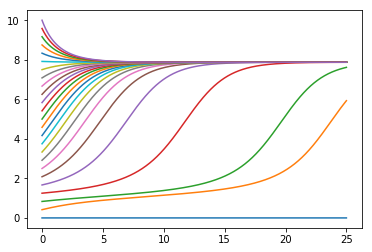

In [3]:
from scipy.integrate import odeint

# N0 = 5
settings.update(predation=1.7)
N0 = np.linspace(0, 10, 25)
t = np.linspace(0, 25, 10000)

def f(N, t):
    return budworm_ode(N, t, **settings)

N = odeint(f, N0, t)
plt.plot(t, N)
plt.show()

In [4]:
def budworm_ode_varenv(N, t, predation, growth_rate, carrying_capacity, characteristic_population):
    r = growth_rate
    K = carrying_capacity
    c = predation
    H = characteristic_population
    return r*N * (1 - N/K) - c(t)*N**2 / (H**2 + N**2)

> ### Note: nested functions
> In our implementation of the Euler-Maruyama algorithm we see that it is possible to define functions within the body of other functions! The inner function is aware of the variables that were defined in the outer function's *scope*.
>
> The inner function is only accessible from inside the outer function in which it is defined. However, it is possible for an outer function to return an inner nested function as a value. Remember: functions are values too!
>
> The following example will give an answer:
> ```python
> def multiply_by(x):
>    def multiply(y):
>        return x*y
>    
>    return multiply
>
> f = multiply_by(6)
> f(7)
> ```

Explain `np.where` and array indexing.

> ### Recap & exercise: vectorized functions
> We'd like to define a piecewise function like this:
> ```python
> def variable_c(t):
>     a = 2.0
>     b = 2.8
>     t1 = 20
>     t2 = 50
>
>     if t < t1:
>         return a
>     elif t > t2:
>         return b
>     else:
>         return a + (b - a) * (t - t1) / (t2 - t1)
> ```
> **Problem 1:** This function could be generalized so that we can use it for other values of `a`, `b`, `t1` and `t2`. Write a function `interpolate_values(t1, a, t2, b)` that returns a new function with the correct behaviour.
>
> **Problem 2:** This particular implementation is not vectorized. We can use `numpy.where` in stead of `if`-statements to make this function faster. Plot your results.
>
> **Problem 3:** Look up the documentation of `numpy.piecewise`. Can we make our implementation even better?

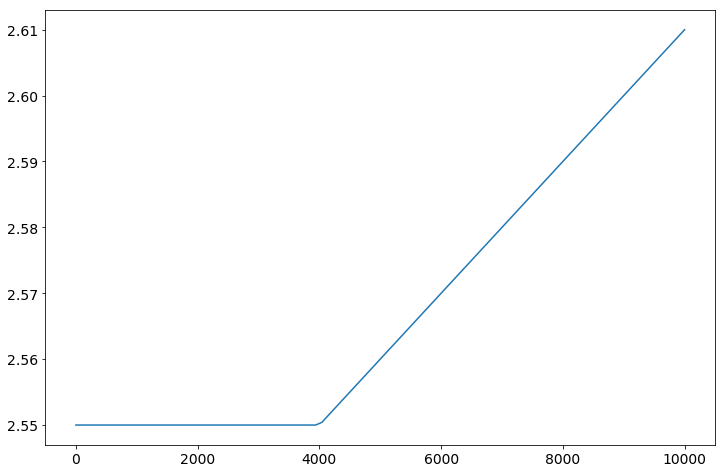

In [58]:
def interpolate_values(t1, a, t2, b):
    def f(t):
        interpolated = a + (b - a) * (t - t1) / (t2 - t1)
        return np.where(
            t < t1, a,
            np.where(t > t2, b, interpolated))
    
    return f

predation = interpolate_values(4000, 2.55, 10000, 2.61)

t = np.linspace(0, 10000, 100)
plt.plot(t, predation(t))
plt.show()

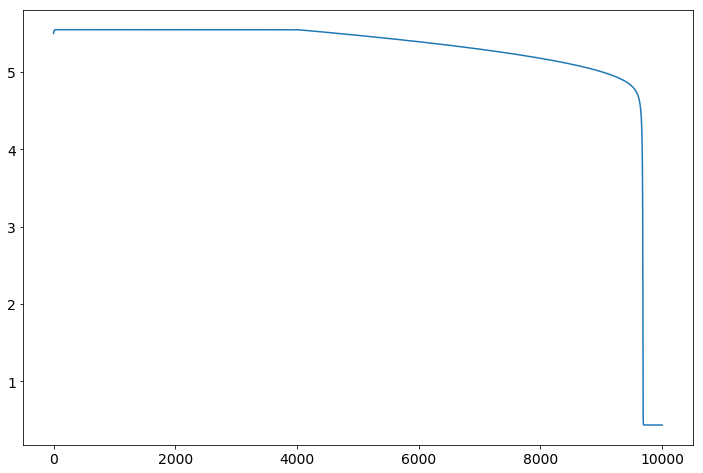

In [59]:
settings.update(predation=predation)
t = np.linspace(0, 10000, 10000)
N_cold = odeint(lambda N, t: budworm_ode_varenv(N, t, **settings), 5.5, t)
plt.plot(t, N_cold)
plt.show()

We create a function ``variable_c`` that interpolates between two chosen values.

> ### Exercise: use the `sdeint` module
> We have now used our own Euler-Maruyama integrator to solve the SDE. There exist better algorithms that can handle more complicated models and better performance. The `sdeint` module already has these algorithms, so we don't have to implement them!
>
> **Problem 3:** Run our SDE using `sdeint.itoint`, and plot the results.
>
> **hint:** `sdeint` integrators don't support passing additional arguments to the functions. First define the functions `f` and `G` that enter into `sdeint.itoint`.

In [60]:
from sdeint import itoint
from scipy.integrate import odeint

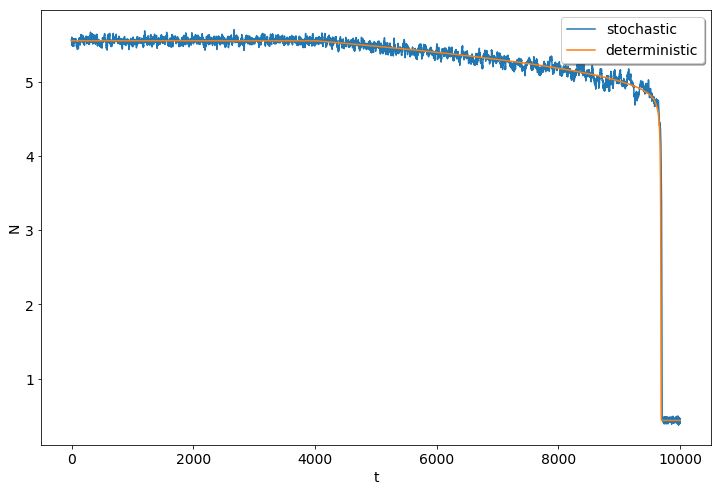

In [67]:
import sdeint

settings.update(predation=predation)

def f(y, t):
    if y <= 0:
        return -y
    else:
        return budworm_ode_varenv(y, t, **settings)

def G(y, t):
    return 0.02

t = np.linspace(0., 10000., 10000)
N = itoint(f, G, 5.55, t).T[0]
N_cold = odeint(f, 5.55, t)

fig = plt.subplot(111)
fig.plot(t, N, label='stochastic')
fig.plot(t, N_cold, label='deterministic')
fig.set_xlabel('t')
fig.set_ylabel('N')
fig.legend(loc='upper right', shadow=True)

plt.savefig('figures/integrated.svg')
plt.show()

### Save integration to disk

In [68]:
np.save("timeseries.npy", np.c_[t, N])